In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))

from UKMovementSensing import hsmm

import pandas as pd
import numpy as np

In [3]:
execfile('config.py')

## Load the data

In [4]:
filenames = os.listdir(subset_path)
filenames = [fn for fn in filenames if os.path.isfile(os.path.join(subset_path,fn))]
datasets = [pd.read_csv(os.path.join(subset_path,fn)) for fn in filenames]
print(len(datasets))

227


In [5]:
for i in range(len(datasets)):
    datasets[i] = datasets[i].set_index('timestamp')
    datasets[i].index = pd.to_datetime(datasets[i].index) 

In [6]:
# Take one example datset and have a look
example_index = 2
example_data = datasets[example_index]

example_data.head()

,acceleration,EN,anglex,angley,anglez,roll_med_acc_x,roll_med_acc_y,roll_med_acc_z,dev_roll_med_acc_x,dev_roll_med_acc_y,dev_roll_med_acc_z,invalid,filename,slot,activity,label,start_time,subset,switched_pos
timestamp,,,,,,,,,,,,,,,,,,,
2015-03-24 04:00:00,0.000985,0.996487,-33.688573,-55.681505,-5.794749,-0.553118,-0.823593,-0.100681,-0.000710,0.001239,0.001243,0,__022800_2015-04-08 11-03-39.bin_day1,1,NaN,NaN,NaN,0,False
2015-03-24 04:00:05,0.001085,0.996119,-33.717287,-55.652101,-5.799117,-0.553118,-0.822688,-0.100681,-0.001656,0.001416,0.001263,0,__022800_2015-04-08 11-03-39.bin_day1,1,NaN,NaN,NaN,0,False
2015-03-24 04:00:10,0.001315,0.997458,-33.690944,-55.682695,-5.778013,-0.553118,-0.823553,-0.100385,-0.001262,0.000472,0.000296,0,__022800_2015-04-08 11-03-39.bin_day1,1,NaN,NaN,NaN,0,False
2015-03-24 04:00:15,0.000954,0.996329,-33.727128,-55.665674,-5.688886,-0.553118,-0.822609,-0.098747,-0.000611,0.000197,0.000789,0,__022800_2015-04-08 11-03-39.bin_day1,1,NaN,NaN,NaN,0,False
2015-03-24 04:00:20,0.001022,0.996196,-33.704179,-55.665525,-5.797123,-0.553118,-0.823101,-0.100681,-0.001005,0.001377,0.000671,0,__022800_2015-04-08 11-03-39.bin_day1,1,NaN,NaN,NaN,0,False


## Prepare data for HSMM

In [7]:
X_list = [d[column_names].as_matrix() for d in datasets]

## Train HSMM

/home/vincent/anaconda3/envs/ukmose/lib/python2.7/site-packages/pybasicbayes/util/stats.py:185: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = np.random.randn(nu,n)
/home/vincent/anaconda3/envs/ukmose/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:895: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


KeyboardInterrupt: 

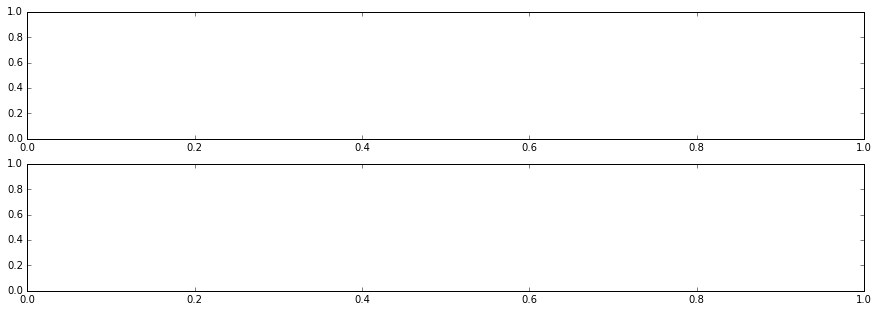

In [8]:
#Note that with many iterations, the visualization becomes badly visible
model, model_dist = hsmm.train_hsmm(X_list, Nmax=Nmax, nr_resamples=nr_resamples, trunc=truncate, visualize=True, example_index=example_index)

## Plot one example

In [ ]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(20, 5))
model.plot_stateseq(example_index)

## Save the data with the states

Save the data including the states found. This labeled data serves as an input to the analyses.

In [ ]:
if not os.path.exists(states_path_model):
        os.makedirs(states_path_model)
for i, dat in enumerate(datasets):
    dat['state'] = model.stateseqs[i]
    fn = str(str(dat['subset'][0]) + dat['filename'][0])+'.csv'
    dat.to_csv(os.path.join(states_path_model, fn))

## Save the model

NB: This removes the data from the model! Only run this if you've saved the data with states.

In [ ]:
import pickle
#Remove the data from the model
model.states_list = []

if not os.path.exists(model_path):
        os.makedirs(model_path)
with open(os.path.join(model_path, model_name+'.pkl'), 'wb') as f:
    pickle.dump(model, file=f)

## Save the config

In [ ]:
from shutil import copyfile

if not os.path.exists(config_path):
    os.makedirs(config_path)
copyfile('config.py', os.path.join(config_path, model_name+'_config.py'))

## Possibly: Apply the model to new data

In [ ]:
# You can apply the model to another list of datasets
new_datasets = datasets # Here you could load your new dataset
for dat in datasets:
    X = dat[column_names].as_matrix()
    prediction = model.predict(X, 0)
    dat['state'] = predictionss[1]